<a href="https://colab.research.google.com/github/orhansonmeztr/junk/blob/main/SimCSE_unsup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install sacremoses -q
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
from math import log2

In [4]:
# os.listdir('drive/MyDrive/transfer/patent')
os.chdir('/content/drive/MyDrive/vectors_via_biogpt_variants/')

In [5]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    #mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        # mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit #, mrr

In [7]:
dset="biotech"
biotech_abstract_SimCSE_unsup_norm = np.load('data_biotech_abstract_SimCSE_unsup_norm.npy')
biotech_title_SimCSE_unsup_norm = np.load('data_biotech_title_SimCSE_unsup_norm.npy')
biotech_abstract_SimCSE_unsup_norm.shape

(484, 1024)

In [8]:
pca_abstract_SimCSE_unsup= PCA().fit(biotech_abstract_SimCSE_unsup_norm)
pca_var_SimCSE_unsup = np.cumsum(pca_abstract_SimCSE_unsup.explained_variance_ratio_)

In [10]:
svd_abstract_SimCSE_unsup = TruncatedSVD(n_iter= 25, n_components = 1024).fit(biotech_abstract_SimCSE_unsup_norm)
svd_var_SimCSE_unsup = np.cumsum(svd_abstract_SimCSE_unsup.explained_variance_ratio_)

In [11]:
print('PCA 100% :',np.where(np.array(pca_var_SimCSE_unsup) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_SimCSE_unsup) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_SimCSE_unsup) >= 0.90)[0][0])

print('SVD 100% :',np.where(np.array(svd_var_SimCSE_unsup) >= 0.99)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_SimCSE_unsup) >= 0.95)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_SimCSE_unsup) >= 0.90)[0][0])

PCA 100% : 137
PCA 95% : 75
PCA 90% : 50
SVD 100% : 138
SVD 95% : 76
SVD 90% : 50


In [13]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save(dset + '_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save(dset + '_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(content_vectors_svd))
    inverse_title = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(title_vectors_svd))

    np.save(dset + '_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save(dset + '_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [14]:
pca_reducer(50, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
pca_reducer(76, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
pca_reducer(138, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
pca_reducer(107, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)

svd_reducer(50, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
svd_reducer(76, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
svd_reducer(138, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)
svd_reducer(107, biotech_abstract_SimCSE_unsup_norm, biotech_title_SimCSE_unsup_norm)

In [15]:
abstract_pca_50 = np.load(dset + '_abst_vectors_norm_pca_50.npy')
title_pca_50 = np.load(dset + '_title_vectors_norm_pca_50.npy')

abstract_pca_76 = np.load(dset + '_abst_vectors_norm_pca_76.npy')
title_pca_76 = np.load(dset + '_title_vectors_norm_pca_76.npy')

abstract_pca_138 = np.load(dset + '_abst_vectors_norm_pca_138.npy')
title_pca_138 = np.load(dset + '_title_vectors_norm_pca_138.npy')

abstract_pca_107 = np.load(dset + '_abst_vectors_norm_pca_107.npy')
title_pca_107 = np.load(dset + '_title_vectors_norm_pca_107.npy')


abstract_svd_50 = np.load(dset + '_abst_vectors_norm_svd_50.npy')
title_svd_50 = np.load(dset + '_title_vectors_norm_svd_50.npy')

abstract_svd_76 = np.load(dset + '_abst_vectors_norm_svd_76.npy')
title_svd_76 = np.load(dset + '_title_vectors_norm_svd_76.npy')

abstract_svd_138 = np.load(dset + '_abst_vectors_norm_svd_138.npy')
title_svd_138 = np.load(dset + '_title_vectors_norm_svd_138.npy')

abstract_svd_107 = np.load(dset + '_abst_vectors_norm_svd_107.npy')
title_svd_107 = np.load(dset + '_title_vectors_norm_svd_107.npy')

In [16]:
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_SimCSE_unsup_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_pca_50 = scann.scann_ops_pybind.builder(abstract_pca_50, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_76 = scann.scann_ops_pybind.builder(abstract_pca_76, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_138 = scann.scann_ops_pybind.builder(abstract_pca_138, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_svd_50 = scann.scann_ops_pybind.builder(abstract_svd_50, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_76 = scann.scann_ops_pybind.builder(abstract_svd_76, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_138 = scann.scann_ops_pybind.builder(abstract_svd_138, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [17]:
raw_idx = []
reduced_idx_pca_50 = []
reduced_idx_svd_50 = []
reduced_idx_pca_76 = []
reduced_idx_svd_76 = []
reduced_idx_pca_138 = []
reduced_idx_svd_138 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_SimCSE_unsup_norm)):
    raw_idx.append(searcher_raw.search(biotech_abstract_SimCSE_unsup_norm[i])[0])
    reduced_idx_pca_50.append(searcher_pca_50.search(title_pca_50[i])[0])
    reduced_idx_svd_50.append(searcher_svd_50.search(title_svd_50[i])[0])
    reduced_idx_pca_76.append(searcher_pca_76.search(title_pca_76[i])[0])
    reduced_idx_svd_76.append(searcher_svd_76.search(title_svd_76[i])[0])
    reduced_idx_pca_138.append(searcher_pca_138.search(title_pca_138[i])[0])
    reduced_idx_svd_138.append(searcher_svd_138.search(title_svd_138[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])

In [19]:
k = [1,3,5,10,15,20,30]
ap_pca_50, hit_pca_50 = metrics_calculator(raw_idx,reduced_idx_pca_50, k )
ap_svd_50, hit_svd_50 = metrics_calculator(raw_idx,reduced_idx_svd_50, k )

ap_pca_76, hit_pca_76 = metrics_calculator(raw_idx,reduced_idx_pca_76, k )
ap_svd_76, hit_svd_76 = metrics_calculator(raw_idx,reduced_idx_svd_76, k )

ap_pca_138, hit_pca_138 = metrics_calculator(raw_idx,reduced_idx_pca_138, k )
ap_svd_138, hit_svd_138 = metrics_calculator(raw_idx,reduced_idx_svd_138, k )

ap_pca_107, hit_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )

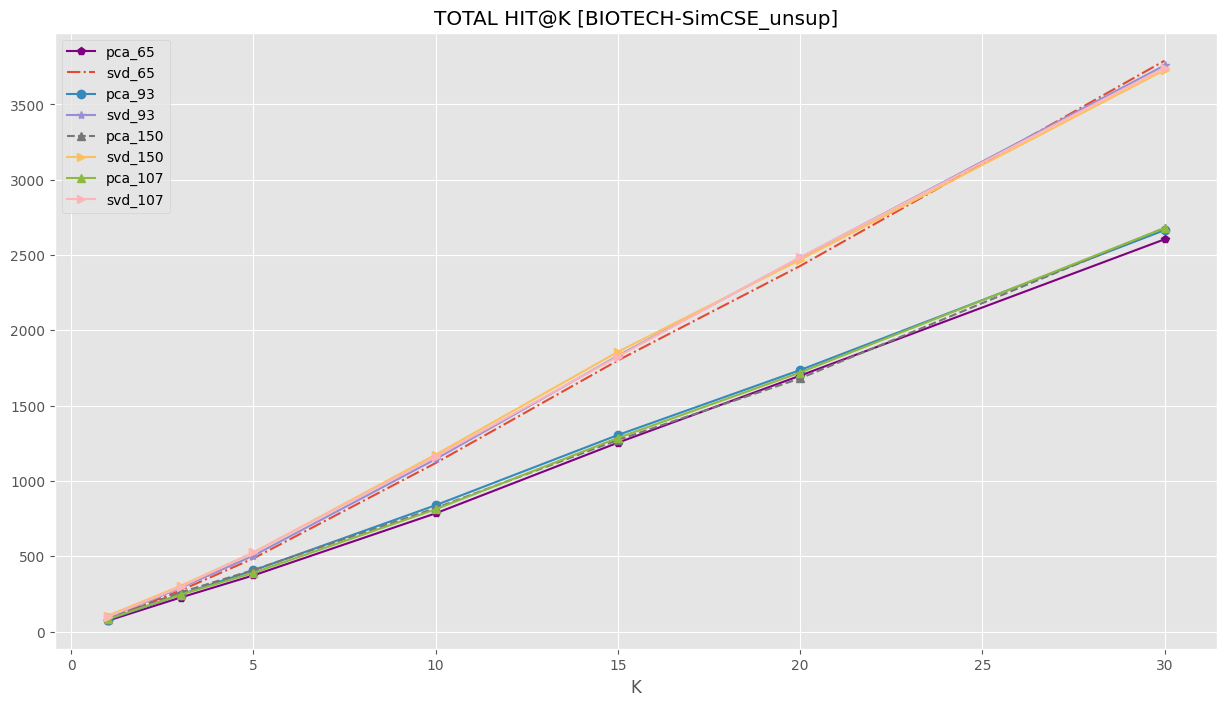

In [21]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_50, '-p', color = 'purple')
plt.plot(k,hit_svd_50, '-.')
plt.plot(k,hit_pca_76, '-o')
plt.plot(k,hit_svd_76, '-*')
plt.plot(k,hit_pca_138, '--^')
plt.plot(k,hit_svd_138, '>-')
plt.plot(k,hit_pca_107, '^-')
plt.plot(k,hit_svd_107, '->')

plt.title('TOTAL HIT@K [BIOTECH-SimCSE_unsup]')
plt.legend(['pca_65','svd_65','pca_93','svd_93','pca_150','svd_150','pca_107','svd_107'])
plt.xlabel('K');

In [20]:
print(hit_pca_50)
print(hit_pca_76)
print(hit_pca_138)
print(hit_pca_107)
print("-"*50)
print(hit_svd_50)
print(hit_svd_76)
print(hit_svd_138)
print(hit_svd_107)

[72, 226, 373, 785, 1254, 1699, 2604]
[78, 246, 406, 839, 1305, 1736, 2665]
[86, 260, 409, 820, 1272, 1681, 2680]
[82, 245, 390, 812, 1286, 1720, 2679]
--------------------------------------------------
[82, 273, 486, 1119, 1800, 2427, 3790]
[94, 290, 504, 1145, 1831, 2482, 3759]
[105, 303, 525, 1175, 1857, 2468, 3727]
[97, 296, 526, 1161, 1826, 2485, 3743]
